We reverse engineer the L26H9 head on don't say prompts.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.nn import LogitLens, TunedLens

from pii import prompt_data, utils
from pii.subnet_flow.masked_model import PerTokenMaskedTransformer

torch.set_grad_enabled(False)

### Load model / lenses

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)
logit_lens = LogitLens.from_model(hf_model).to("cuda")
tuned_lens = TunedLens.from_model_and_pretrained(hf_model).to("cuda")

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions'

### Develop prompts

In [76]:
def get_dontsay_prompt(question: str, forbidden_word: str):
    return f"""\
[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. \
You are not allowed to say the forbidden word {forbidden_word}. \
<</SYS>>
I'm going to ask you a sport question. Some example sports are baseball and tennis. \
{question} [/INST] \
"""


# question = "Miles Davis plays the"
# forbidden_words = ["apple", "Trumpet"]
question = "Tom Brady plays the sport of"
forbidden_words = ["apple", "football"]
# question = "Carlos Alcaraz plays the sport of"
# forbidden_words = ["apple", "Tennis"]
# question = "The capital of Germany is"
# forbidden_words = ["apple", "Berlin"]

# question = "An example of a red and crunchy fruit is a"
# forbidden_words = ["football", "apple"]

tl_model.remove_all_hook_fns(including_permanent=True)
for i, forbidden_word in enumerate(forbidden_words):
    prompt = get_dontsay_prompt(question, forbidden_word)
    print(prompt)
    utils.get_top_responses(
        prompt=prompt,
        model=tl_model,
        top_k=5,
    )
    if i == 0:
        print()

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word apple. <</SYS>>
I'm going to ask you a sport question. Some example sports are baseball and tennis. Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 24.95 Prob: 99.70% Tokens: ( 8914) |Football|</s>|
Rank 1. Logit: 18.53 Prob:  0.16% Tokens: ( 5733) |football|</s>|
Rank 2. Logit: 17.67 Prob:  0.07% Tokens: (18322) |FO|OT|B|ALL|</s>|
Rank 3. Logit: 16.60 Prob:  0.02% Tokens: (25167) |NFL|</s>|
Rank 4. Logit: 16.16 Prob:  0.02% Tokens: (13440) |Foot|ball|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word. You are not allowed to say the forbidden word football. <</SYS>>
I'm going to ask you a sport question. Some example sports are baseball and tennis. Tom Brady plays the sport of [/INST] 
Rank 0. Logit: 17.80 Prob: 66.68% Tokens: (21850) |Basketball|</s>|
Rank 1. Logit: 16.26 Prob: 14.35% Tokens: (18585) |Sure|!|Tom|Br|

### Cache activations

In [77]:
prompt_dict = dict(
    dontsay_base=prompt_data.PromptData.get_data(get_dontsay_prompt(question, forbidden_words[0]), tl_model),
    dontsay_competing=prompt_data.PromptData.get_data(get_dontsay_prompt(question, forbidden_words[1]), tl_model),
)

### Do patching

In [78]:
prompt_type = "dontsay"
pd_base = prompt_dict[f"{prompt_type}_base"]
pd_comp = prompt_dict[f"{prompt_type}_competing"]

In [79]:
ld_comp_0 = prompt_data.get_ablated_logits(
    pd=pd_comp,
    tl_model=tl_model,
)

  0%|          | 0/32 [00:00<?, ?it/s]

In [80]:
for ld, title in [
    (ld_comp_0, "dontsay competing (effect est. via 0-ablation)"),
]:
    orig_logits = ld.pd.final_logits
    logits, labels = ld.get_logits_and_labels()

    orig_log_odds = orig_logits.softmax(dim=-1).logit()
    orig_log_odds_diff = (
        orig_logits[pd_comp.ml_token] - orig_logits[pd_base.ml_token]
    )
    log_odds = logits.softmax(dim=-1).logit()

    utils.plot_head_data(
        lines=[
            (
                f"|{pd_base.ml_str}|",
                (orig_log_odds - log_odds)[:, pd_base.ml_token].exp(),
                labels,
            ),
            (
                f"|{pd_comp.ml_str}|",
                (orig_log_odds - log_odds)[:, pd_comp.ml_token].exp(),
                labels,
            ),
        ],
        annotation_text=ld_comp_0.pd.prompt.split("\n")[-1],
        title=title
        + f"\n(|{pd_comp.ml_str}| : |{pd_base.ml_str}| = {orig_log_odds_diff.exp():.4f})",
        yaxis_title="Odds Ratio",
        xaxis_title="Components",
        yaxis=dict(type="log"),
        height=420,
        width=800,
    ).show()

In [81]:
df = ld_comp_0.get_cumulative_ablations(
    tl_model=tl_model,
    target_token = pd_base.ml_token,
    top_k=10,
)

utils.plot_head_data(
    lines=[
        (f"true", df.log_odds / np.log(10), df.label),
        (f"pred", df.pred_log_odds / np.log(10), df.label),
    ],
    spacing=1,
    annotation_text=ld_comp_0.pd.prompt.split("\n")[-1],
    title="dontsay competing, multi-component ablation",
    yaxis_title="Log_10 Odds",
    xaxis_title="Ablated Components (cumulative)",
    height=420, width=800
).show()

  0%|          | 0/11 [00:00<?, ?it/s]

# Begin reverse engineering of L26H9

In [82]:
ld = ld_comp_0
cache = ld.pd.cache
if "blocks.0.attn.hook_result" not in cache.cache_dict:
    cache.compute_head_results()

wtok = ld.pd.ml_token
ftok = tl_model.to_single_token("football")
fpos = 35
assert ld.pd.tokens[fpos].item() == ftok

wtok_str = tl_model.to_string(wtok)
ftok_str = tl_model.to_string(ftok)

LAYER = 26
HEAD = 9
HEAD_STR = f"L{LAYER}H{HEAD}"
ATTN_SCALE = tl_model.blocks[LAYER].attn.attn_scale

print("Wrong token:", f"|{wtok_str}|", wtok)
print("Forbidden token:", f"|{ftok_str}|", ftok)
print("Attention scale:", f"{ATTN_SCALE:.4f}")

Wrong token: |Basketball| 21850
Forbidden token: |football| 5733
Attention scale: 11.3137


### What does the head downweight / upweight (per ablation)?

Tokens most downweighted by L26H9
Football (-0.990) football (-0.904) football (-0.805) Foot (-0.537) footballer (-0.405) 
Fußball (-0.285) футбо (-0.275) Father (-0.239) piłkar (-0.239) fool (-0.226) 
protocol (-0.221) callback (-0.211) FO (-0.200) tocol (-0.183) foot (-0.181) 
TextView (-0.180) Food (-0.177) fo (-0.166) footer (-0.161) roid (-0.156) 
neighborhood (-0.143) Museum (-0.141) footer (-0.140) Foot (-0.139) 足 (-0.138) 
Fernández (-0.137) Basketball (-0.133) FO (-0.133) feet (-0.130) Firefox (-0.126) 
Baseball (-0.120) father (-0.118) ności (-0.115) Fo (-0.110) Tennessee (-0.110) 
breakfast (-0.108) fútbol (-0.108) Trop (-0.107) Official (-0.106) 口 (-0.106) 
follow (-0.105) raste (-0.102) Fern (-0.101) officials (-0.100) orithms (-0.100) 
вет (-0.098) female (-0.095) aircraft (-0.092) Film (-0.092) Protocol (-0.092) 

Tokens most upweighted by L26H9
device (0.391) devices (0.365) Device (0.354) device (0.354) Device (0.344) 
src (0.307) sake (0.304) omon (0.292) resource (0.

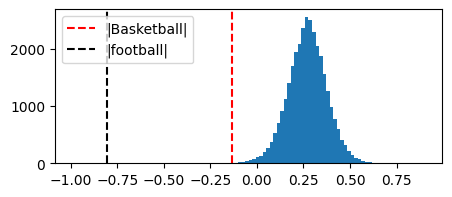

In [83]:
orig_logits = ld.pd.final_logits
logits = ld.attn_head_logits[LAYER][HEAD]

orig_log_odds = orig_logits.softmax(dim=-1).logit()
log_odds = logits.softmax(dim=-1).logit()

log10_bf = (orig_log_odds - log_odds) / np.log(10)

print(f"Tokens most downweighted by {HEAD_STR}")
top_tokens = torch.topk(-log10_bf, 50).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({log10_bf[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

print()
print(f"Tokens most upweighted by {HEAD_STR}")
top_tokens = torch.topk(log10_bf, 10).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({log10_bf[token].item() / np.log(10):.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(log10_bf.cpu().numpy(), bins=100)
plt.axvline(
    log10_bf[wtok].item(),
    color="red",
    linestyle="--",
    label=f"|{wtok_str}|",
)
plt.axvline(
    log10_bf[ftok].item(),
    color="black",
    linestyle="--",
    label=f"|{ftok_str}|",
)
plt.legend()
plt.show()

### Attention pattern on L26H9

In [84]:
pattern = cache["pattern", LAYER][HEAD]
print(f"{HEAD_STR} Attention Pattern:")
display(
    cv_tokens.colored_tokens(["<< bos >>"] + ld.pd.token_strs[1:], pattern[-1])
)
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + ld.pd.token_strs[1:], np.arange(len(ld.pd.token_strs))
    )
)

L26H9 Attention Pattern:


### OV circuit behavior on forbidden token

In [85]:
E_f = tl_model.W_E[ftok]
U_f = tl_model.W_U[:, ftok]
vs = cache["v", LAYER][:, HEAD]
attn_pattern = cache["pattern", LAYER][HEAD, -1]
result = cache["result", LAYER][-1, HEAD]

ln_final = tl_model.ln_final
ln1 = tl_model.blocks[LAYER].ln1
W_V = tl_model.W_V[LAYER, HEAD]
b_V = tl_model.b_V[LAYER, HEAD]
W_O = tl_model.W_O[LAYER, HEAD]


def print_stat(label: str, val: torch.Tensor):
    print(f"{label:<64}: {val.item():.6f}")


def f_log10_prob(x):
    return (ln_final(x) @ tl_model.W_U).log_softmax(dim=-1)[ftok] / np.log(10)


print(f"pattern[fpos] = {attn_pattern[fpos]:.3f}")
print()
print(f"{HEAD_STR} stats:")
print_stat("f_log10_prob(result)", f_log10_prob(result))
print_stat(
    "f_log10_odds(pattern @ vs @ W_O)",
    f_log10_prob(attn_pattern @ vs @ W_O),
)
print_stat(
    "f_log10_odds(pattern[fpos] * vs[fpos] @ W_O)",
    f_log10_prob(attn_pattern[fpos] * vs[fpos] @ W_O),
)
print()
print_stat(
    "f_log10_odds(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)",
    f_log10_prob(attn_pattern[fpos] * ln1(E_f) @ W_V @ W_O),
)
print_stat(
    "f_log10_odds(pattern[fpos] * E[fpos] @ W_V @ W_O)",
    f_log10_prob(attn_pattern[fpos] * E_f @ W_V @ W_O),
)
print()
print_stat(
    "softmax_log10(pattern[fpos] * E[fpos] @ W_V @ W_O @ U)[ftok]",
    (attn_pattern[fpos] * E_f @ W_V @ W_O @ tl_model.W_U).log_softmax(dim=-1)[
        ftok
    ]
    / np.log(10),
)
print_stat("log10(1 / d_vocab)", np.log10(1 / tl_model.cfg.d_vocab))

pattern[fpos] = 0.475

L26H9 stats:
f_log10_prob(result)                                            : -13.569826
f_log10_odds(pattern @ vs @ W_O)                                : -13.569826
f_log10_odds(pattern[fpos] * vs[fpos] @ W_O)                    : -13.812345

f_log10_odds(pattern[fpos] * ln1(E[fpos]) @ W_V @ W_O)          : -10.500295
f_log10_odds(pattern[fpos] * E[fpos] @ W_V @ W_O)               : -10.262682

softmax_log10(pattern[fpos] * E[fpos] @ W_V @ W_O @ U)[ftok]    : -4.515049
log10(1 / d_vocab)                                              : -4.505150


### OV circuit behavior on embedding vectors

tensor(-10.4772, device='cuda:0')
Tokens L26H9 most downweights from raw embedding
service (-24.816) development (-24.785) follow (-23.956) read (-23.809) family (-23.591) 
features (-23.356) release (-23.291) services (-23.018) develop (-22.865) individual (-22.673) 
reading (-22.344) developed (-22.172) study (-21.810) feature (-21.598) organization (-21.538) 
change (-21.503) force (-21.477) Development (-21.119) leader (-21.114) available (-20.921) 
writing (-20.819) professional (-20.665) studies (-20.559) image (-20.432) company (-20.269) 
examples (-20.218) developing (-20.209) students (-20.058) Service (-20.028) use (-19.985) 
leaders (-19.951) following (-19.933) address (-19.911) government (-19.838) changes (-19.831) 
forces (-19.791) provided (-19.756) people (-19.699) issues (-19.673) write (-19.647) 
cause (-19.643) security (-19.586) country (-19.450) see (-19.449) companies (-19.366) 
service (-19.334) issue (-19.316) follows (-19.284) released (-19.264) Study (-19.244

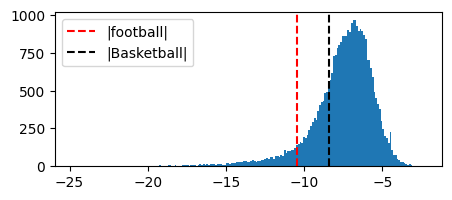

In [86]:
# Very big, 32k x 32k
log10_resp_mat = (
    ln_final(tl_model.W_E @ W_V @ W_O) @ tl_model.W_U
).log_softmax(dim=-1) / np.log(10)

print(log10_resp_mat[ftok, ftok])
print(f"Tokens {HEAD_STR} most downweights from raw embedding")
top_tokens = torch.topk(-log10_resp_mat.diag(), 50).indices
for i, token in enumerate(top_tokens):
    print(
        f"{tl_model.to_string(token)} ({log10_resp_mat.diag()[token].item():.3f})",
        end=" ",
    )
    if i % 5 == 4:
        print()

plt.figure(figsize=(5, 2))
plt.hist(log10_resp_mat.diag().cpu().numpy(), bins=200)
plt.axvline(
    log10_resp_mat[ftok, ftok].item(),
    color="red",
    linestyle="--",
    label=f"|{ftok_str}|",
)
plt.axvline(
    log10_resp_mat[wtok, wtok].item(),
    color="black",
    linestyle="--",
    label=f"|{wtok_str}|",
)
plt.legend()
plt.show()

### Forbidden word token enrichment over layers -- attention effect

resid.shape torch.Size([27, 74, 4096])
f_attn_logits.shape torch.Size([27])
ablt_patterns.shape torch.Size([27, 74])
tensor(0.4753, device='cuda:0')


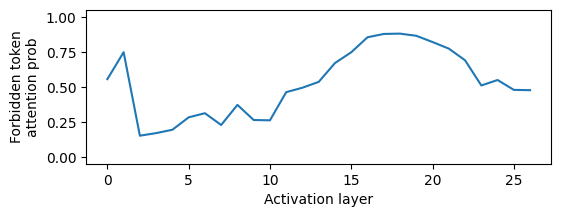

In [87]:
rot_q_final = cache["rot_q", LAYER][-1, HEAD]

resid = torch.stack([cache["resid_pre", l] for l in range(LAYER + 1)])
print("resid.shape", resid.shape)
assert resid.shape == (LAYER + 1, ld.pd.n_tokens, tl_model.cfg.d_model)
assert tl_model.b_K.abs().max() == 0

resid_norm = tl_model.blocks[LAYER].ln1(resid)
ks = resid_norm @ tl_model.W_K[LAYER, HEAD]
ks = einops.rearrange(ks, "layer pos d -> 1 pos layer d")
rot_ks = tl_model.blocks[LAYER].attn.apply_rotary(ks)
rot_ks = einops.rearrange(rot_ks, "1 pos layer d -> layer pos d")
f_rot_ks = rot_ks[:, fpos]

f_attn_scores = (f_rot_ks @ rot_q_final) / ATTN_SCALE
print("f_attn_logits.shape", f_attn_scores.shape)

ablt_attn_scores = einops.repeat(
    cache["attn_scores", LAYER][HEAD, -1],
    "pos -> layer pos",
    layer=len(f_attn_scores)
).clone()
ablt_attn_scores[:, fpos] = f_attn_scores

ablt_patterns = ablt_attn_scores.softmax(dim=-1)
print("ablt_patterns.shape", ablt_patterns.shape)

print(ablt_patterns[:, fpos][-1])
plt.figure(figsize=(6,2))
plt.plot(ablt_patterns[:, fpos].cpu().numpy())
plt.ylim(-0.05, 1.05)
plt.xlabel("Activation layer")
plt.ylabel("Forbidden token\nattention prob")
plt.show()

cv_attention.attention_pattern(
    ld.pd.token_strs,
    ablt_patterns, 
    mask_upper_tri=False,
)

### Last token query enrichment over layers -- attention effect

rot_ks.shape torch.Size([56, 128])
final_resid.shape torch.Size([27, 56, 4096])
qs.shape torch.Size([1, 56, 27, 128])
rot_qs.shape torch.Size([27, 56, 128])
final_rot_qs.shape torch.Size([27, 128])
attn.shape torch.Size([27, 56])
tensor(0.6469, device='cuda:0')


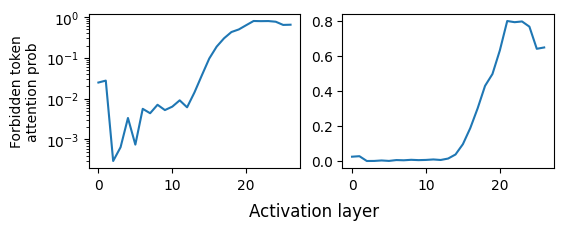

In [16]:
rot_ks = cache["rot_k", LAYER][:, HEAD]
print("rot_ks.shape", rot_ks.shape)

final_resid = torch.stack([cache["resid_pre", l] for l in range(LAYER + 1)])
print("final_resid.shape", final_resid.shape)

final_resid_norm = tl_model.blocks[LAYER].ln1(final_resid)
qs = final_resid_norm @ tl_model.W_Q[LAYER, HEAD]
qs = einops.rearrange(qs, "layer pos d -> 1 pos layer d")
print("qs.shape", qs.shape)

rot_qs = tl_model.blocks[LAYER].attn.apply_rotary(qs)
rot_qs = einops.rearrange(rot_qs, "1 pos layer d -> layer pos d")
print("rot_qs.shape", rot_qs.shape)

final_rot_qs = rot_qs[:, -1]
print("final_rot_qs.shape", final_rot_qs.shape)

logits = (final_rot_qs @ rot_ks.T) / ATTN_SCALE
attn = logits.softmax(dim=-1)
print("attn.shape", attn.shape)

print(attn[LAYER, fpos])

plt.figure(figsize=(6,2))

plt.subplot(1, 2, 1)
plt.plot(attn[:, fpos].cpu().numpy())
plt.yscale("log")
plt.ylabel("Forbidden token\nattention prob")

plt.subplot(1, 2, 2)
plt.plot(attn[:, fpos].cpu().numpy())

# supxlabel but shifted down
plt.gcf().supxlabel("Activation layer", y=-0.15)
plt.show()

# cv_attention.attention_pattern(
#     ld.pd.token_strs,
#     attn, 
#     mask_upper_tri=False,
# )

### Query vec for football x Key vec for apple

In [64]:
fws: list[str] = ["apple", "football", "tennis", "basketball", "river"]

fw_pd_dict = {
    fw: prompt_data.PromptData.get_data(
        get_dontsay_prompt(question, fw),
        tl_model,
    )
    for fw in fws
}

for fw, pdata in fw_pd_dict.items():
    print(fw, pdata.ml_token, pdata.ml_str, len(pdata.tokens))

apple 8914 Football 56
football 23185 Baseball 56
tennis 8914 Football 56
basketball 8914 Football 56
river 8914 Football 56


In [65]:
for fw1 in fws:
    for fw2 in fws:
        rot_ks1 = fw_pd_dict[fw1].cache["rot_k", LAYER][:, HEAD]
        rot_q2 = fw_pd_dict[fw2].cache["rot_q", LAYER][-1, HEAD]

        scores = (rot_ks1 @ rot_q2) / ATTN_SCALE
        attn = scores.softmax(dim=-1)

        print(f"keys: {fw1:<10}; query: {fw2:<10}; attn: {attn[fpos].item():.4f}")

keys: apple     ; query: apple     ; attn: 0.0888
keys: apple     ; query: football  ; attn: 0.1664
keys: apple     ; query: tennis    ; attn: 0.2331
keys: apple     ; query: basketball; attn: 0.1479
keys: apple     ; query: river     ; attn: 0.1104
keys: football  ; query: apple     ; attn: 0.7973
keys: football  ; query: football  ; attn: 0.6469
keys: football  ; query: tennis    ; attn: 0.9270
keys: football  ; query: basketball; attn: 0.8796
keys: football  ; query: river     ; attn: 0.7976
keys: tennis    ; query: apple     ; attn: 0.5597
keys: tennis    ; query: football  ; attn: 0.7089
keys: tennis    ; query: tennis    ; attn: 0.6709
keys: tennis    ; query: basketball; attn: 0.7077
keys: tennis    ; query: river     ; attn: 0.6078
keys: basketball; query: apple     ; attn: 0.5806
keys: basketball; query: football  ; attn: 0.6719
keys: basketball; query: tennis    ; attn: 0.8209
keys: basketball; query: basketball; attn: 0.5534
keys: basketball; query: river     ; attn: 0.5388


In [66]:
for fw1 in fws:
    for fw2 in fws:
        ks1 = fw_pd_dict[fw1].cache["k", LAYER][:, HEAD].clone()

        swap_pos = fpos
        tmp = ks1[fpos].clone()
        ks1[fpos] = ks1[swap_pos].clone()
        ks1[swap_pos] = tmp
        rot_ks1 = tl_model.blocks[LAYER].attn.apply_rotary(
            ks1[None, :, None, :]
        )[0, :, 0]

        rot_q2 = fw_pd_dict[fw2].cache["rot_q", LAYER][-1, HEAD]

        scores = (rot_ks1 @ rot_q2) / ATTN_SCALE
        attn = scores.softmax(dim=-1)

        print(
            f"keys: {fw1:<10}; query: {fw2:<10}; attn: {attn[swap_pos].item():.4f}"
        )

keys: apple     ; query: apple     ; attn: 0.0888
keys: apple     ; query: football  ; attn: 0.1664
keys: apple     ; query: tennis    ; attn: 0.2331
keys: apple     ; query: basketball; attn: 0.1479
keys: apple     ; query: river     ; attn: 0.1104
keys: football  ; query: apple     ; attn: 0.7973
keys: football  ; query: football  ; attn: 0.6469
keys: football  ; query: tennis    ; attn: 0.9270
keys: football  ; query: basketball; attn: 0.8796
keys: football  ; query: river     ; attn: 0.7976
keys: tennis    ; query: apple     ; attn: 0.5597
keys: tennis    ; query: football  ; attn: 0.7089
keys: tennis    ; query: tennis    ; attn: 0.6709
keys: tennis    ; query: basketball; attn: 0.7077
keys: tennis    ; query: river     ; attn: 0.6078
keys: basketball; query: apple     ; attn: 0.5806
keys: basketball; query: football  ; attn: 0.6719
keys: basketball; query: tennis    ; attn: 0.8209
keys: basketball; query: basketball; attn: 0.5534
keys: basketball; query: river     ; attn: 0.5388


resid.shape torch.Size([27, 56, 4096])
f_attn_logits.shape torch.Size([27])
ablt_patterns.shape torch.Size([27, 56])
tensor(0.8030, device='cuda:0')


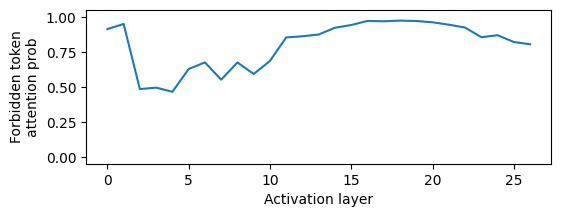

resid.shape torch.Size([27, 56, 4096])
f_attn_logits.shape torch.Size([27])
ablt_patterns.shape torch.Size([27, 56])
tensor(0.6469, device='cuda:0')


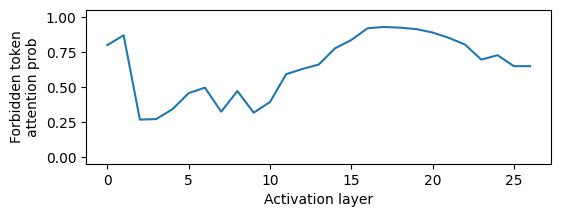

resid.shape torch.Size([27, 56, 4096])
f_attn_logits.shape torch.Size([27])
ablt_patterns.shape torch.Size([27, 56])
tensor(0.8470, device='cuda:0')


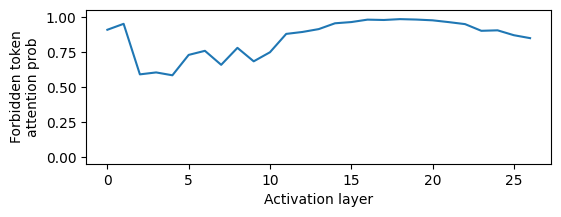

resid.shape torch.Size([27, 56, 4096])
f_attn_logits.shape torch.Size([27])
ablt_patterns.shape torch.Size([27, 56])
tensor(0.8427, device='cuda:0')


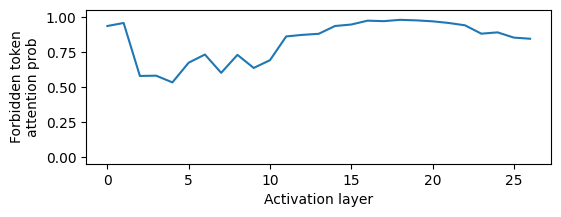

resid.shape torch.Size([27, 56, 4096])
f_attn_logits.shape torch.Size([27])
ablt_patterns.shape torch.Size([27, 56])
tensor(0.8045, device='cuda:0')


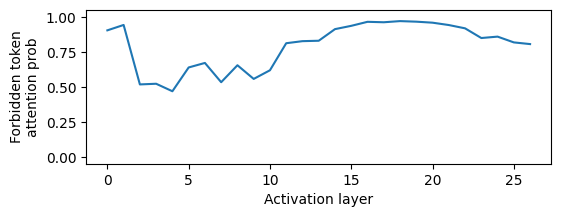

In [63]:
for fw2 in fws:
    rot_q2 = fw_pd_dict[fw2].cache["rot_q", LAYER][-1, HEAD]

    resid = torch.stack([cache["resid_pre", l] for l in range(LAYER + 1)])
    print("resid.shape", resid.shape)
    assert resid.shape == (LAYER + 1, ld.pd.n_tokens, tl_model.cfg.d_model)
    assert tl_model.b_K.abs().max() == 0

    resid_norm = tl_model.blocks[LAYER].ln1(resid)
    ks = resid_norm @ tl_model.W_K[LAYER, HEAD]
    ks = einops.rearrange(ks, "layer pos d -> 1 pos layer d")
    rot_ks = tl_model.blocks[LAYER].attn.apply_rotary(ks)
    rot_ks = einops.rearrange(rot_ks, "1 pos layer d -> layer pos d")
    f_rot_ks = rot_ks[:, fpos]

    f_attn_scores = (f_rot_ks @ rot_q2) / ATTN_SCALE
    print("f_attn_logits.shape", f_attn_scores.shape)

    ablt_attn_scores = einops.repeat(
        cache["attn_scores", LAYER][HEAD, -1],
        "pos -> layer pos",
        layer=len(f_attn_scores)
    ).clone()
    ablt_attn_scores[:, fpos] = f_attn_scores

    ablt_patterns = ablt_attn_scores.softmax(dim=-1)
    print("ablt_patterns.shape", ablt_patterns.shape)

    print(ablt_patterns[:, fpos][-1])
    plt.figure(figsize=(6,2))
    plt.plot(ablt_patterns[:, fpos].cpu().numpy())
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Activation layer")
    plt.ylabel("Forbidden token\nattention prob")
    plt.show()

cv_attention.attention_pattern(
    ld.pd.token_strs,
    ablt_patterns, 
    mask_upper_tri=False,
)

### Last token query enrichment -- masking

In [20]:
display(
    cv_tokens.colored_tokens(
        ["<< bos >>"] + ld.pd.token_strs[1:], np.arange(len(ld.pd.token_strs))
    )
)

attn_del_q = torch.zeros_like(ld.pd.tokens).bool()
attn_del_q[-5:] = 1

# These tokens will not be attended to
attn_del_k = torch.zeros_like(ld.pd.tokens).bool()
attn_del_k[9:40] = 1
attn_del_k[41:43] = 1
attn_del_k[44:-5] = 1

display(
    cv_tokens.colored_tokens(
        ld.pd.token_strs,
        attn_del_q.float(),
    )
)
display(
    cv_tokens.colored_tokens(
        ld.pd.token_strs,
        attn_del_k.float(),
    )
)

attn_del_pattern = (attn_del_q[:, None] * attn_del_k[None, :]).float()
attn_del_pattern[-1, -5:-2] = 1
attn_del_pattern[-1, -1] = 1
attn_del_pattern[-2, -5] = 1
attn_del_pattern[-2, 40] = 1
attn_del_pattern[-3, -4] = 1
attn_del_pattern[-4, -4] = 1
attn_del_pattern[-5:-2, 40] = 1
attn_del_pattern[-3, 43] = 1
attn_del_pattern[-2, 43] = 1
attn_del_pattern[-5, 40] = 1

cv_attention.attention_pattern(
    tokens=ld.pd.token_strs,
    attention=attn_del_pattern,
)

In [21]:
raw_logits = []
probs = []
for mask_limit in tqdm(range(LAYER + 2)):
    mtl_model = PerTokenMaskedTransformer(
        tl_model,
        base_prompt=ld.pd.prompt,
    )

    for i in range(mask_limit):
        mask = mtl_model.masks[f"{i}_attn_pattern"]
        mask[:] *= 1.0 - attn_del_pattern
    mtl_model.masks[f"{LAYER}_attn_pattern"][HEAD, -1, :] = 1

    _, mcache = mtl_model.tl_model.run_with_cache(
        ld.pd.prompt,
        remove_batch_dim=True,
        names_filter=[
            tl_utils.get_act_name("z", l) for l in range(tl_model.cfg.n_layers)
        ]
        + [
            tl_utils.get_act_name("attn", l)
            for l in range(tl_model.cfg.n_layers)
        ],
    )
    mcache.compute_head_results()

    logits = logit_lens.forward(mcache["result", LAYER][-1, HEAD], idx=LAYER)
    raw_logit = logits[ftok]
    raw_logits.append(raw_logit.item())

    prob = logits.softmax(dim=-1)[ftok]
    probs.append(prob.item())

tl_model.remove_all_hook_fns(including_permanent=True)

  0%|          | 0/28 [00:00<?, ?it/s]

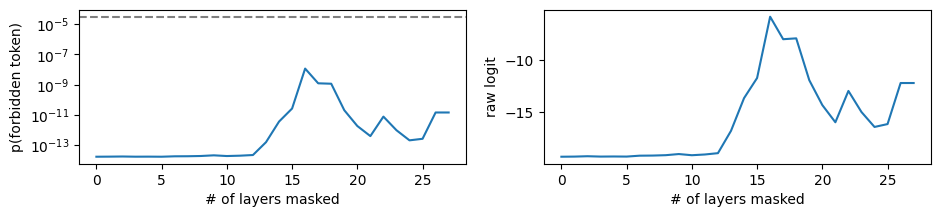

-12.211824417114258
L26H9 Attention Pattern:


In [22]:
plt.figure(figsize=(11, 2))

plt.subplot(1, 2, 1)
plt.plot(probs)
plt.axhline(
    1 / hf_model.config.vocab_size,
    color="black",
    linestyle="--",
    alpha=0.5,
    zorder=-1,
)
plt.yscale("log")
plt.ylabel("p(forbidden token)")
plt.xlabel("# of layers masked")

plt.subplot(1, 2, 2)
plt.plot(raw_logits)
plt.ylabel("raw logit")
plt.xlabel("# of layers masked")
plt.show()

pattern = mcache["pattern", LAYER][HEAD]
print(raw_logits[-1])
print(f"{HEAD_STR} Attention Pattern:")
display(
    cv_tokens.colored_tokens(["<< bos >>"] + ld.pd.token_strs[1:], pattern[-1])
)